# Chest Xray Pneumonia Classification

<img src="images/chest_xray.jpeg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Summary
This project used nearly 6,000 pediatric xray images from the Guangzhou Women and Children’s Medical Center to develop an image classification model that can accurately identify the presence of pneumonia. The model has been developed for a local hospital that is looking to increase their efficiency and accuracy in diagnosing pneumonia in order to improve patient experience and outcome. The data was processed using ImageDataGenerator from the keras library, and then split into training, validation, and test datasets using sklearn's train_test_split. The training set was further split into a smaller training set for faster processing on initial modeling iterations. The project uses convolutional neural networks from the keras library. Over several iterations, the model complexity of the model architecture is adjusted through the number of layers, the number of convolutional filters, and the number of neurons. Additionally, hyperparameter tuning was conducted and several regularization techniques are applied to reduce overfitting. Each model iteration was validated on a subset of the training data. The final CNN model was evaluated on a separate test dataset and showed a 96% accuracy and 94% recall.

## Business Understanding
A local hospital is looking to improve the efficiency and accuracy in which they diagnose pediatric pneumonia. Using a classification model will decrease patient wait times and reduce errors, making overall patient experience better. 

## Data Understanding
The data for this project comes from the Guangzhou Women and Children’s Medical Center. It consists of 5,956 chest x-ray images of patients ages 1-5. The dataset has a class imbalance of 73% pneumonia and 27% normal.

In [2]:
#import all necessary libraries
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import numpy as np
import random
from skimage.segmentation import mark_boundaries
from lime import lime_image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import talos
from sklearn.metrics import recall_score

In [2]:
# define the file pathway for all datasets
train_folder = 'chest_xray/train/'
test_folder = 'chest_xray/test/'
val_folder = 'chest_xray/val/'

In [3]:
# get all the data in the test directory, and rescale
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, batch_size=624) 

# get all the data in the validation directory, and rescale
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, batch_size=16)

# get all the data in the train directory, and rescale
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, batch_size=5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [4]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [94]:
# Explore the datasets
print ("Number of training samples: " + str(train_images.shape[0]))
print ("Number of testing samples: " + str(test_images.shape[0]))
print ("Number of validation samples: " + str(val_images.shape[0]))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


In [ ]:
# reshape label data
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [ ]:
# combine three original datasets into one for data and labels
X = np.concatenate((train_images, test_images, val_images))
y = np.concatenate((train_y, test_y, val_y))

In [217]:
# total dataset size
X.shape

(5856, 256, 256, 3)

In [204]:
# counts the number of pneuomina images vs normal
counts = np.unique(y, return_counts=True)[1]

Pneumonia:  4273
Normal:  1583


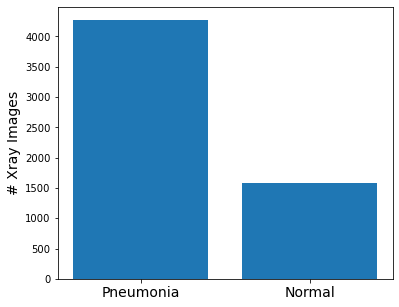

In [216]:
# plot the class distribution
fig, ax = plt.subplots(figsize=(6, 5))
plt.bar(['Pneumonia', 'Normal'], counts);
plt.ylabel('# Xray Images', fontsize=14);
plt.xticks(fontsize=14)
print("Pneumonia: ", counts[0])
print("Normal: ", counts[1])

## Data Preparation
The ratio of the default train, test, and validation dataset sizes is not ideal, so the data is combined and then split into new train, test, and validation datasets. The training dataset if further split so that the initial models can be trained on a smaller dataset that will process faster.

In [9]:
# intial split of data into traiing and test sets with 15% test size
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=879, 
                                                        random_state=42)

In [10]:
# second split of data into training and validation sets with 15% val size
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, 
                                                  test_size=879,
                                                  random_state=42)

In [11]:
# third split of data into smaller training and val sets
X_train_sub, x1, y_train_sub, y1 = train_test_split(X_train, y_train, 
                                                  test_size=3545,
                                                  random_state=42)

X_val_sub, x2, y_val_sub, y2 = train_test_split(X_val, y_val, 
                                                test_size=761,
                                                random_state=42)

In [96]:
# new dataset breakdown
print("Full Number of Training Samples: ", y_train.shape[0])
print("SubSet Number of Training Samples: ", y_train_sub.shape[0])
print("Full Number of Validation Samples: ", y_val.shape[0])
print("Subset Number of Validation Samples: ", y_val_sub.shape[0])
print("Number of Test Samples: ", y_test.shape[0])

Full Number of Training Samples:  4098
SubSet Number of Training Samples:  553
Full Number of Validation Samples:  879
Subset Number of Validation Samples:  118
Number of Test Samples:  879


## Baseline CNN Model #1
For the first CNN model, a simple one convolutional layer architecture is used.

In [43]:
# start sequential model
cnn_model_1 = models.Sequential()

# add convolutional and pooling layers
cnn_model_1.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_1.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
cnn_model_1.add(layers.Flatten())

# add dense hidden layer and output
cnn_model_1.add(layers.Dense(4, activation='relu'))
cnn_model_1.add(layers.Dense(1, activation='sigmoid'))

In [44]:
# compile model
cnn_model_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
# fit model to training data and validate
cnn_history_1 = cnn_model_1.fit(X_train_sub,
                    y_train_sub,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/30
18/18 [==============================] - 4s 207ms/step - loss: 0.7060 - accuracy: 0.6980 - val_loss: 0.6862 - val_accuracy: 0.6780
Epoch 2/30
18/18 [==============================] - 4s 200ms/step - loss: 0.6803 - accuracy: 0.7306 - val_loss: 0.6799 - val_accuracy: 0.6780
Epoch 3/30
18/18 [==============================] - 4s 201ms/step - loss: 0.6723 - accuracy: 0.7306 - val_loss: 0.6743 - val_accuracy: 0.6780
Epoch 4/30
18/18 [==============================] - 4s 213ms/step - loss: 0.6650 - accuracy: 0.7306 - val_loss: 0.6691 - val_accuracy: 0.6780
Epoch 5/30
18/18 [==============================] - 4s 214ms/step - loss: 0.6582 - accuracy: 0.7306 - val_loss: 0.6644 - val_accuracy: 0.6780
Epoch 6/30
18/18 [==============================] - 4s 208ms/step - loss: 0.6521 - accuracy: 0.7306 - val_loss: 0.6604 - val_accuracy: 0.6780
Epoch 7/30
18/18 [==============================] - 4s 204ms/step - loss: 0.6466 - accuracy: 0.7306 - val_loss: 0.6569 - val_accuracy: 0.6780
Epoch 

In [ ]:
# define function to plot accuracy and loss of model
def plot_training(history):
    #get history of model
    history_dict = history.history
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # define accruacy and loss values
    acc_values = history_dict['accuracy'] 
    val_acc_values = history_dict['val_accuracy']
    
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss']
     
    # set x(epoch) range    
    epochs = range(1, len(acc_values) + 1)
    
    # plot accuracy for training and validation
    ax[0].plot(epochs, acc_values, label='Training acc')
    ax[0].plot(epochs, val_acc_values, label='Validation acc')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend();
    
    # plot loss for training and validation
    ax[1].plot(epochs, loss_values, label='Training loss')
    ax[1].plot(epochs, val_loss_values, label='Validation loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend();
    
    print("Final Training Accuracy:", acc_values[-1])
    print("Final Validation Accuracy:", val_acc_values[-1])

Final Training Accuracy: 0.7305606007575989
Final Validation Accuracy: 0.6779661178588867


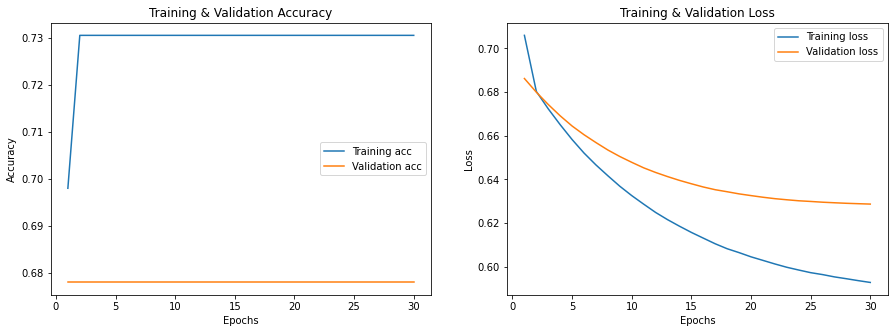

In [46]:
plot_training(cnn_history_1)

### CNN 2
The first CNN model was underfit to the data, so for this second model the architecture complexity is increased by adding a second convolutional layer, decreasing the filter dimensions, and increasing the number of neurons in the dense layer.

In [55]:
# start sequential model
cnn_model_2 = models.Sequential()

# add convolutional and pooling layers
cnn_model_2.add(layers.Conv2D(8, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
cnn_model_2.add(layers.Flatten())

# add dense hidden layer and output
cnn_model_2.add(layers.Dense(20, activation='relu'))
cnn_model_2.add(layers.Dense(1, activation='sigmoid'))

In [56]:
# compile model
cnn_model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [57]:
# fit model to training data and validate
cnn_history_2 = cnn_model_2.fit(X_train_sub,
                    y_train_sub,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/30
18/18 [==============================] - 5s 275ms/step - loss: 0.6375 - accuracy: 0.7197 - val_loss: 0.6423 - val_accuracy: 0.6780
Epoch 2/30
18/18 [==============================] - 5s 282ms/step - loss: 0.5740 - accuracy: 0.7306 - val_loss: 0.6356 - val_accuracy: 0.6780
Epoch 3/30
18/18 [==============================] - 5s 276ms/step - loss: 0.5644 - accuracy: 0.7306 - val_loss: 0.5839 - val_accuracy: 0.6780
Epoch 4/30
18/18 [==============================] - 5s 267ms/step - loss: 0.5436 - accuracy: 0.7306 - val_loss: 0.5804 - val_accuracy: 0.6780
Epoch 5/30
18/18 [==============================] - 5s 282ms/step - loss: 0.4917 - accuracy: 0.7306 - val_loss: 0.5048 - val_accuracy: 0.6780
Epoch 6/30
18/18 [==============================] - 5s 291ms/step - loss: 0.5038 - accuracy: 0.7306 - val_loss: 0.5244 - val_accuracy: 0.6780
Epoch 7/30
18/18 [==============================] - 5s 273ms/step - loss: 0.4787 - accuracy: 0.7306 - val_loss: 0.4536 - val_accuracy: 0.6780
Epoch 

Final Training Accuracy: 0.8770343661308289
Final Validation Accuracy: 0.8644067645072937


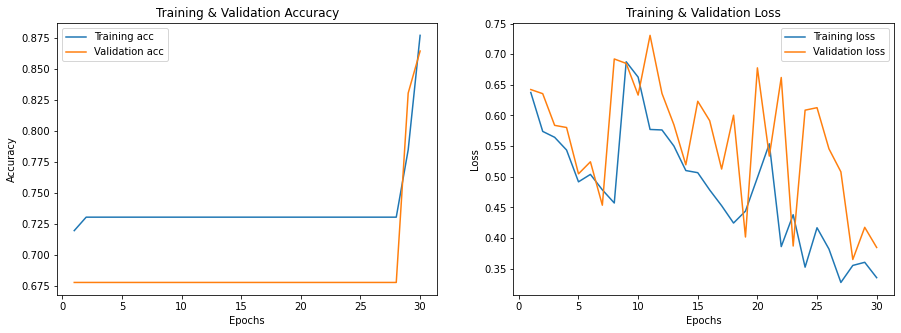

In [60]:
plot_training(cnn_history_2)

The second CNN model is improved, but higher training and validation accuracies are still desired.

## CNN Model 3
The second model performed better, but is still sub-optimal, so for the third model the architecture complexity is further increased to include more filters in the 2 convolutional layers and more neurons in the dense layer.

In [33]:
# start sequential model
cnn_model_3 = models.Sequential()

# add convolutional and pooling layers
cnn_model_3.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
cnn_model_3.add(layers.Flatten())

# add dense hidden layer and output
cnn_model_3.add(layers.Dense(50, activation='relu'))
cnn_model_3.add(layers.Dense(1, activation='sigmoid'))

In [34]:
# compile model
cnn_model_3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
# fit model to training data and validate
cnn_history_3 = cnn_model_3.fit(X_train_sub,
                    y_train_sub,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/30
18/18 [==============================] - 8s 471ms/step - loss: 0.6068 - accuracy: 0.7179 - val_loss: 0.6090 - val_accuracy: 0.6780
Epoch 2/30
18/18 [==============================] - 8s 445ms/step - loss: 0.5370 - accuracy: 0.7306 - val_loss: 0.5674 - val_accuracy: 0.6780
Epoch 3/30
18/18 [==============================] - 8s 463ms/step - loss: 0.5338 - accuracy: 0.7107 - val_loss: 0.5592 - val_accuracy: 0.6780
Epoch 4/30
18/18 [==============================] - 9s 483ms/step - loss: 0.5454 - accuracy: 0.7143 - val_loss: 0.5074 - val_accuracy: 0.6780
Epoch 5/30
18/18 [==============================] - 9s 522ms/step - loss: 0.4717 - accuracy: 0.7939 - val_loss: 0.4444 - val_accuracy: 0.8475
Epoch 6/30
18/18 [==============================] - 9s 507ms/step - loss: 0.4765 - accuracy: 0.7577 - val_loss: 0.4934 - val_accuracy: 0.7034
Epoch 7/30
18/18 [==============================] - 9s 476ms/step - loss: 0.4691 - accuracy: 0.7740 - val_loss: 0.3876 - val_accuracy: 0.8814
Epoch 

Final Training Accuracy: 0.9367088675498962
Final Validation Accuracy: 0.8728813529014587


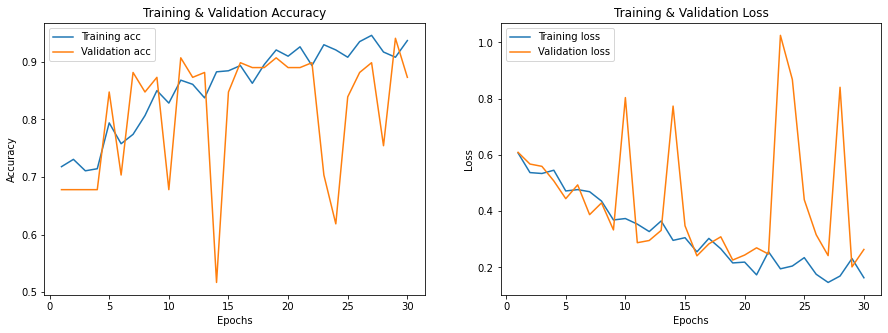

In [59]:
plot_training(cnn_history_3)

The third model improved upon the training score, though the model is now slightly overfit.

### CNN 4
The third model showed improvement in the training and validation accuracy, however, it is modestly overfit. Before applying regularization techniques, the epochs and batches hyperparameters are adjusted to see if the performance be be imporved further.

In [105]:
# start sequential model
cnn_model_4 = models.Sequential()

# add convolutional and pooling layers
cnn_model_4.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))

cnn_model_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
cnn_model_4.add(layers.Flatten())

# add dense hidden layer and output
cnn_model_4.add(layers.Dense(50, activation='relu'))
cnn_model_4.add(layers.Dense(1, activation='sigmoid'))

In [106]:
# compile model
cnn_model_4.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [107]:
# fit model to training data and validate with adjusted hyperparameters
cnn_history_4 = cnn_model_4.fit(X_train_sub,
                    y_train_sub,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/100
9/9 [==============================] - 8s 903ms/step - loss: 0.6395 - accuracy: 0.6998 - val_loss: 0.6442 - val_accuracy: 0.7627
Epoch 2/100
9/9 [==============================] - 8s 854ms/step - loss: 0.5661 - accuracy: 0.7342 - val_loss: 0.5406 - val_accuracy: 0.7373
Epoch 3/100
9/9 [==============================] - 7s 830ms/step - loss: 0.5417 - accuracy: 0.7342 - val_loss: 0.5166 - val_accuracy: 0.7373
Epoch 4/100
9/9 [==============================] - 7s 818ms/step - loss: 0.5029 - accuracy: 0.7577 - val_loss: 0.4888 - val_accuracy: 0.7373
Epoch 5/100
9/9 [==============================] - 8s 916ms/step - loss: 0.4778 - accuracy: 0.7830 - val_loss: 0.4649 - val_accuracy: 0.7458
Epoch 6/100
9/9 [==============================] - 8s 909ms/step - loss: 0.5378 - accuracy: 0.7758 - val_loss: 0.5062 - val_accuracy: 0.7373
Epoch 7/100
9/9 [==============================] - 8s 841ms/step - loss: 0.5302 - accuracy: 0.7848 - val_loss: 0.4258 - val_accuracy: 0.7712
Epoch 8/100
9

Epoch 59/100
9/9 [==============================] - 7s 813ms/step - loss: 0.1316 - accuracy: 0.9530 - val_loss: 0.1861 - val_accuracy: 0.9407
Epoch 60/100
9/9 [==============================] - 7s 816ms/step - loss: 0.1317 - accuracy: 0.9458 - val_loss: 0.1888 - val_accuracy: 0.9407
Epoch 61/100
9/9 [==============================] - 7s 810ms/step - loss: 0.1228 - accuracy: 0.9512 - val_loss: 0.1785 - val_accuracy: 0.9407
Epoch 62/100
9/9 [==============================] - 7s 816ms/step - loss: 0.1297 - accuracy: 0.9512 - val_loss: 0.1770 - val_accuracy: 0.9407
Epoch 63/100
9/9 [==============================] - 7s 812ms/step - loss: 0.1298 - accuracy: 0.9494 - val_loss: 0.2216 - val_accuracy: 0.9153
Epoch 64/100
9/9 [==============================] - 7s 814ms/step - loss: 0.1558 - accuracy: 0.9403 - val_loss: 0.2223 - val_accuracy: 0.9153
Epoch 65/100
9/9 [==============================] - 7s 819ms/step - loss: 0.1342 - accuracy: 0.9476 - val_loss: 0.2481 - val_accuracy: 0.9068
Epoch 

Final Training Accuracy: 0.9674502611160278
Final Validation Accuracy: 0.9067796468734741


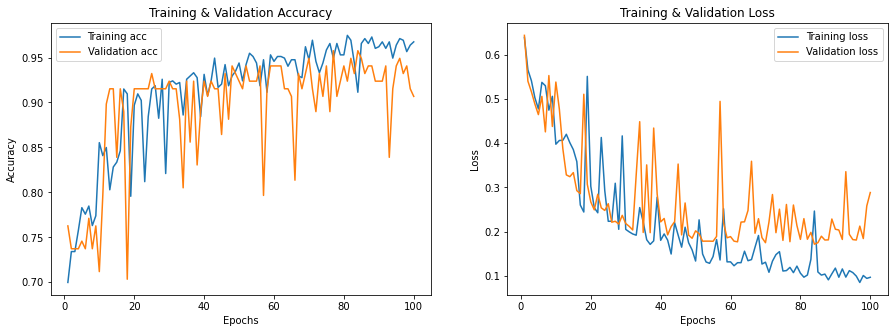

In [109]:
plot_training(cnn_history_4)

Larger epoch and batch sizes did increase the accuracy of the model, thus these hyperparameters will be kept moving forward.

### CNN Model 5 - Dropout
The fourth model showed improved training accuracy, but is still overfit, so regularization techniques will be applied, starting with including a dropout rate.

In [110]:
# start sequential model
cnn_model_5 = models.Sequential()
cnn_model_5.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))

# add convolutional pooling and dropout layers
cnn_model_5.add(layers.MaxPooling2D((2, 2)))
cnn_model_5.add(layers.Dropout(0.3))

cnn_model_5.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_5.add(layers.MaxPooling2D((2, 2)))
cnn_model_5.add(layers.Dropout(0.3))

# flatten pooled featrue maps
cnn_model_5.add(layers.Flatten())

# add dense hidden layer with dropout and output
cnn_model_5.add(layers.Dense(50, activation='relu'))
cnn_model_5.add(layers.Dropout(0.3))
cnn_model_5.add(layers.Dense(1, activation='sigmoid'))

In [111]:
# compile model
cnn_model_5.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [112]:
# fit model to training data and validate
cnn_history_5 = cnn_model_5.fit(X_train_sub,
                    y_train_sub,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/100
9/9 [==============================] - 9s 1s/step - loss: 1.1801 - accuracy: 0.6691 - val_loss: 0.6567 - val_accuracy: 0.7373
Epoch 2/100
9/9 [==============================] - 9s 983ms/step - loss: 0.6022 - accuracy: 0.7269 - val_loss: 0.6452 - val_accuracy: 0.7373
Epoch 3/100
9/9 [==============================] - 9s 984ms/step - loss: 0.6080 - accuracy: 0.7269 - val_loss: 0.6396 - val_accuracy: 0.7373
Epoch 4/100
9/9 [==============================] - 9s 997ms/step - loss: 0.6020 - accuracy: 0.7306 - val_loss: 0.6271 - val_accuracy: 0.7373
Epoch 5/100
9/9 [==============================] - 9s 1s/step - loss: 0.5746 - accuracy: 0.7306 - val_loss: 0.6293 - val_accuracy: 0.7373
Epoch 6/100
9/9 [==============================] - 9s 985ms/step - loss: 0.5492 - accuracy: 0.7306 - val_loss: 0.6354 - val_accuracy: 0.7373
Epoch 7/100
9/9 [==============================] - 9s 967ms/step - loss: 0.5463 - accuracy: 0.7306 - val_loss: 0.5984 - val_accuracy: 0.7373
Epoch 8/100
9/9 [==

Epoch 59/100
9/9 [==============================] - 9s 968ms/step - loss: 0.2480 - accuracy: 0.9096 - val_loss: 0.3049 - val_accuracy: 0.8559
Epoch 60/100
9/9 [==============================] - 9s 961ms/step - loss: 0.2554 - accuracy: 0.9005 - val_loss: 0.3310 - val_accuracy: 0.9153
Epoch 61/100
9/9 [==============================] - 9s 970ms/step - loss: 0.2434 - accuracy: 0.9186 - val_loss: 0.3264 - val_accuracy: 0.8983
Epoch 62/100
9/9 [==============================] - 9s 973ms/step - loss: 0.2921 - accuracy: 0.8861 - val_loss: 0.2613 - val_accuracy: 0.9068
Epoch 63/100
9/9 [==============================] - 9s 972ms/step - loss: 0.2711 - accuracy: 0.8969 - val_loss: 0.3584 - val_accuracy: 0.8814
Epoch 64/100
9/9 [==============================] - 9s 964ms/step - loss: 0.2539 - accuracy: 0.9024 - val_loss: 0.4689 - val_accuracy: 0.7288
Epoch 65/100
9/9 [==============================] - 9s 961ms/step - loss: 0.2900 - accuracy: 0.8987 - val_loss: 0.2674 - val_accuracy: 0.8983
Epoch 

Final Training Accuracy: 0.9294756054878235
Final Validation Accuracy: 0.7796609997749329


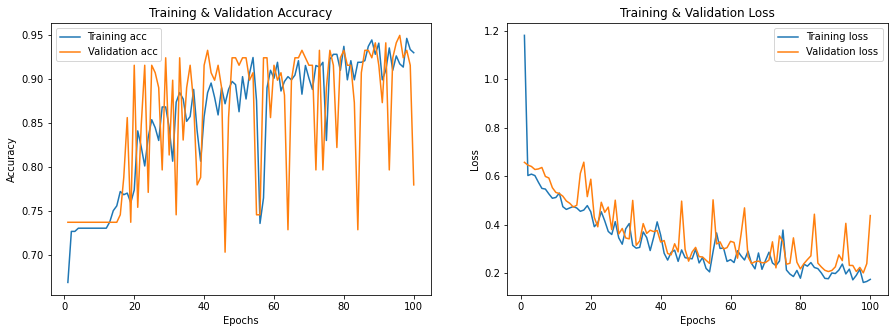

In [113]:
plot_training(cnn_history_5)

Including a dropout rate showed no improvement in the model outcome.

### CNN 6 - Regularizer
Including a dropout rate did not improve the model. As a next step a regularizer will be added to the convolutional layers.

In [114]:
# start sequential model
cnn_model_6 = models.Sequential()

# add convolutional layers with regularizer and pooling layers
cnn_model_6.add(layers.Conv2D(16, (3, 3), activation='relu',
                              kernel_regularizer=regularizers.l2(l=0.001),
                              input_shape=(256 ,256,  3)))
cnn_model_6.add(layers.MaxPooling2D((2, 2)))

cnn_model_6.add(layers.Conv2D(32, (3, 3), activation='relu', 
                              kernel_regularizer=regularizers.l2(l=0.001)))
cnn_model_6.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
cnn_model_6.add(layers.Flatten())

# add dense hidden layer and output
cnn_model_6.add(layers.Dense(50, activation='relu'))
cnn_model_6.add(layers.Dense(1, activation='sigmoid'))

In [115]:
# compile model
cnn_model_6.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [116]:
# fit model to training data and validate
cnn_history_6 = cnn_model_6.fit(X_train_sub,
                    y_train_sub,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/100
9/9 [==============================] - 7s 819ms/step - loss: 0.6503 - accuracy: 0.6655 - val_loss: 0.6637 - val_accuracy: 0.8898
Epoch 2/100
9/9 [==============================] - 7s 804ms/step - loss: 0.6265 - accuracy: 0.7541 - val_loss: 0.5531 - val_accuracy: 0.7373
Epoch 3/100
9/9 [==============================] - 7s 804ms/step - loss: 0.5872 - accuracy: 0.7396 - val_loss: 0.6299 - val_accuracy: 0.7373
Epoch 4/100
9/9 [==============================] - 7s 807ms/step - loss: 0.5324 - accuracy: 0.7559 - val_loss: 0.6813 - val_accuracy: 0.5508
Epoch 5/100
9/9 [==============================] - 7s 804ms/step - loss: 0.5518 - accuracy: 0.7523 - val_loss: 0.4772 - val_accuracy: 0.7966
Epoch 6/100
9/9 [==============================] - 7s 810ms/step - loss: 0.5185 - accuracy: 0.7884 - val_loss: 0.4678 - val_accuracy: 0.7542
Epoch 7/100
9/9 [==============================] - 7s 804ms/step - loss: 0.4918 - accuracy: 0.7920 - val_loss: 0.5027 - val_accuracy: 0.7458
Epoch 8/100
9

Epoch 59/100
9/9 [==============================] - 7s 816ms/step - loss: 0.1440 - accuracy: 0.9620 - val_loss: 0.2847 - val_accuracy: 0.8983
Epoch 60/100
9/9 [==============================] - 7s 814ms/step - loss: 0.1893 - accuracy: 0.9349 - val_loss: 0.2090 - val_accuracy: 0.9322
Epoch 61/100
9/9 [==============================] - 7s 810ms/step - loss: 0.1485 - accuracy: 0.9656 - val_loss: 0.2407 - val_accuracy: 0.9153
Epoch 62/100
9/9 [==============================] - 1287s 143s/step - loss: 0.1449 - accuracy: 0.9566 - val_loss: 0.2059 - val_accuracy: 0.9153
Epoch 63/100
9/9 [==============================] - 9s 949ms/step - loss: 0.1598 - accuracy: 0.9458 - val_loss: 0.2054 - val_accuracy: 0.9237
Epoch 64/100
9/9 [==============================] - 8s 919ms/step - loss: 0.1538 - accuracy: 0.9656 - val_loss: 0.2020 - val_accuracy: 0.9492
Epoch 65/100
9/9 [==============================] - 8s 904ms/step - loss: 0.1283 - accuracy: 0.9656 - val_loss: 0.4259 - val_accuracy: 0.8644
Epoc

Final Training Accuracy: 0.978300154209137
Final Validation Accuracy: 0.9406779408454895


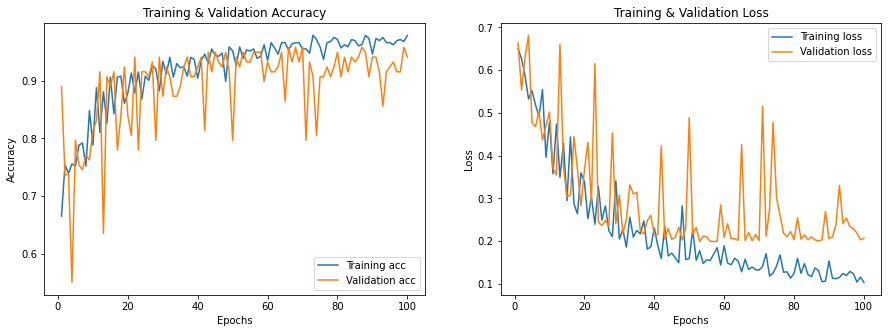

In [117]:
plot_training(cnn_history_6)

Adding a regularizer to the convolutional layers imporved the accuracy and reduced the overfitting, and is currently the best model.

#### CNN 7 - Early Stopping
As a final step, and early stopping method will be applied to see if it can perform better than the regularized model.

In [118]:
# start sequential model
cnn_model_7 = models.Sequential()

# add convolutional and pooling layers
cnn_model_7.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_7.add(layers.MaxPooling2D((2, 2)))

cnn_model_7.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_7.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
cnn_model_7.add(layers.Flatten())

# add dense hidden layer and output
cnn_model_7.add(layers.Dense(50, activation='relu'))
cnn_model_7.add(layers.Dense(1, activation='sigmoid'))

In [119]:
# compile model
cnn_model_7.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [120]:
# Define the early stopping parameters
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='cnn_model_7', monitor='val_loss',
                                  save_best_only=True)]

In [121]:
# fit model to training data and validate with early stopping callback
cnn_history_7 = cnn_model_7.fit(X_train_sub,
                    y_train_sub,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val_sub, y_val_sub),
                    callbacks=early_stopping)

Epoch 1/100
9/9 [==============================] - 9s 990ms/step - loss: 0.5925 - accuracy: 0.7306 - val_loss: 0.5562 - val_accuracy: 0.7373
Epoch 2/100
9/9 [==============================] - 8s 927ms/step - loss: 0.5849 - accuracy: 0.7306 - val_loss: 0.5362 - val_accuracy: 0.7373
Epoch 3/100
9/9 [==============================] - 7s 816ms/step - loss: 0.5567 - accuracy: 0.7523 - val_loss: 0.5725 - val_accuracy: 0.7373
Epoch 4/100
9/9 [==============================] - 8s 835ms/step - loss: 0.5252 - accuracy: 0.7486 - val_loss: 0.5385 - val_accuracy: 0.7373
Epoch 5/100
9/9 [==============================] - 8s 834ms/step - loss: 0.4651 - accuracy: 0.7722 - val_loss: 0.5779 - val_accuracy: 0.7373
Epoch 6/100
9/9 [==============================] - 9s 972ms/step - loss: 0.5193 - accuracy: 0.7957 - val_loss: 0.4380 - val_accuracy: 0.7627
Epoch 7/100
9/9 [==============================] - 7s 826ms/step - loss: 0.4890 - accuracy: 0.7812 - val_loss: 0.4450 - val_accuracy: 0.9068
Epoch 8/100
9

9/9 [==============================] - 8s 912ms/step - loss: 0.2329 - accuracy: 0.9132 - val_loss: 0.1775 - val_accuracy: 0.9492
Epoch 43/100
9/9 [==============================] - 7s 810ms/step - loss: 0.1272 - accuracy: 0.9566 - val_loss: 0.2302 - val_accuracy: 0.9068
Epoch 44/100
9/9 [==============================] - 7s 813ms/step - loss: 0.1402 - accuracy: 0.9512 - val_loss: 0.2166 - val_accuracy: 0.9068
Epoch 45/100
9/9 [==============================] - 7s 819ms/step - loss: 0.1429 - accuracy: 0.9458 - val_loss: 0.1881 - val_accuracy: 0.9237
Epoch 46/100
9/9 [==============================] - 7s 815ms/step - loss: 0.1196 - accuracy: 0.9566 - val_loss: 0.1828 - val_accuracy: 0.9407
Epoch 47/100
9/9 [==============================] - 8s 936ms/step - loss: 0.1794 - accuracy: 0.9403 - val_loss: 0.1709 - val_accuracy: 0.9407
Epoch 48/100
9/9 [==============================] - 7s 819ms/step - loss: 0.1230 - accuracy: 0.9602 - val_loss: 0.1762 - val_accuracy: 0.9407
Epoch 49/100
9/9 [=

In [122]:
# Load the best (saved) model
saved_model = load_model('cnn_model_7')

In [123]:
# evaluate saved model on training data
saved_model.evaluate(X_train_sub_2, y_train_sub_2)

18/18 [==============================] - 2s 84ms/step - loss: 0.0951 - accuracy: 0.9747


[0.095072902739048, 0.9746835231781006]

In [124]:
# evaluate saved model on vlaidation data
saved_model.evaluate(X_val_sub_2, y_val_sub_2)

4/4 [==============================] - 0s 63ms/step - loss: 0.1642 - accuracy: 0.9576


[0.1641789823770523, 0.9576271176338196]

The early stopping model produced a similar training accuracy to the regularized model, with slightly less overfitting, therfore this model will be selected as the final model and trained on the entirety of the training data.

## Final Model Evaluation

In [127]:
# start sequential model
final_model = models.Sequential()

# add convolutional and pooling layers
final_model.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
final_model.add(layers.Flatten())

# add dense hidden layer and output
final_model.add(layers.Dense(50, activation='relu'))
final_model.add(layers.Dense(1, activation='sigmoid'))

In [128]:
# compile model
final_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [129]:
# Define the early stopping callback
final_early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='final_model', monitor='val_loss',
                                  save_best_only=True)]

In [130]:
# fit model to total training data and validate
final_model_history = final_model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=final_early_stopping)

Epoch 1/100
65/65 [==============================] - 106s 2s/step - loss: 0.5735 - accuracy: 0.7211 - val_loss: 0.9239 - val_accuracy: 0.2787
Epoch 2/100
65/65 [==============================] - 59s 915ms/step - loss: 0.4795 - accuracy: 0.7543 - val_loss: 0.9799 - val_accuracy: 0.7213
Epoch 3/100
65/65 [==============================] - 60s 930ms/step - loss: 0.4329 - accuracy: 0.8070 - val_loss: 0.4540 - val_accuracy: 0.7645
Epoch 4/100
65/65 [==============================] - 62s 956ms/step - loss: 0.3465 - accuracy: 0.8536 - val_loss: 1.0072 - val_accuracy: 0.7258
Epoch 5/100
65/65 [==============================] - 61s 934ms/step - loss: 0.3078 - accuracy: 0.8824 - val_loss: 1.3122 - val_accuracy: 0.3993
Epoch 6/100
65/65 [==============================] - 59s 911ms/step - loss: 0.2732 - accuracy: 0.8882 - val_loss: 0.6469 - val_accuracy: 0.6917
Epoch 7/100
65/65 [==============================] - 59s 910ms/step - loss: 0.2633 - accuracy: 0.8929 - val_loss: 0.7117 - val_accuracy: 0

In [4]:
# Load the final model
final_saved_model = load_model('final_model')

In [16]:
# Final training accruacy and loss
final_saved_model.evaluate(X_train, y_train)

129/129 [==============================] - 14s 105ms/step - loss: 0.1136 - accuracy: 0.9597


[0.11355015635490417, 0.9597364664077759]

In [219]:
# Evaluate final model on test set
test_preds = final_saved_model.predict_classes(X_test)
test_accuracy = final_saved_model.evaluate(X_val, y_val)[1]
test_recall = recall_score(preds, y_test)

print("Test Accuracy: ", test_accuracy)
print("Test Recall: ", test_recall)

28/28 [==============================] - 3s 93ms/step - loss: 0.1283 - accuracy: 0.9579
Test Accuracy:  0.9579067230224609
Test Recall:  0.940677966101695


In [65]:
final_saved_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 50)                6150450   
_________________________________________________________________
dense_37 (Dense)             (None, 1)               

The final model is a convolutional neural network model. It consists of 2 convolutional layers, 2 pooling layers, a flattening layer, and two final dense layers. The convolutional layers have filters of size (3,3). The first layer has 16 filters, followed by 32 filters in the second. Max pooling is done with a (2,2) dimension. The first dense layer contains 50 neurons, and the output layer contains one neuron with a sigmoid activation function. The final model has a 96% accuracy in predicting pneumonia and a 94% recall.

### Further Model Evaluation

#### Visualizing Intermediates

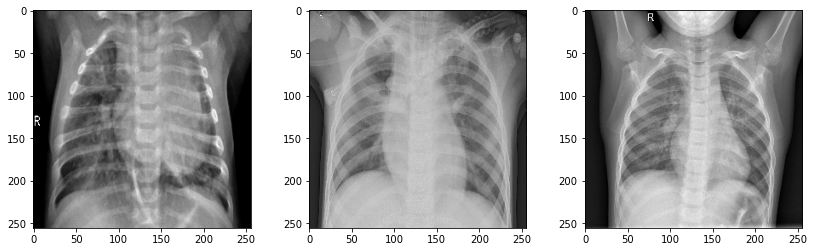

In [3]:
# define image paths
bacteria_img_path = 'chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
viral_img_path = 'chest_xray/test/PNEUMONIA/person10_virus_35.jpeg'
normal_img_path = 'chest_xray/train/NORMAL/IM-0115-0001.jpeg'

# Load images of each type
bacteria_img = image.load_img(bacteria_img_path, target_size=(256, 256))
viral_img = image.load_img(viral_img_path, target_size=(256, 256))
normal_img = image.load_img(normal_img_path, target_size=(256, 256))

# convert images to arrays
bacteria_img_tensor = image.img_to_array(bacteria_img)
viral_img_tensor = image.img_to_array(viral_img)
normal_img_tensor = image.img_to_array(normal_img)

bacteria_img_tensor = np.expand_dims(bacteria_img_tensor, axis=0)
viral_img_tensor = np.expand_dims(viral_img_tensor, axis=0)
normal_img_tensor = np.expand_dims(normal_img_tensor, axis=0)


# Follow the Original Model Preprocessing
bacteria_img_tensor /= 255.
viral_img_tensor /= 255.
normal_img_tensor /= 255.

#Preview images
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))

ax[0].imshow(bacteria_img_tensor[0])
ax[1].imshow(viral_img_tensor[0])
ax[2].imshow(normal_img_tensor[0])
plt.show()

In [10]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in final_saved_model.layers[:8]]

# make a model to display the feature maps
activation_model = models.Model(inputs=final_saved_model.input, outputs=layer_outputs)

In [11]:
# Returns an array for each activation layer
activations = activation_model.predict(bacteria_img_tensor)

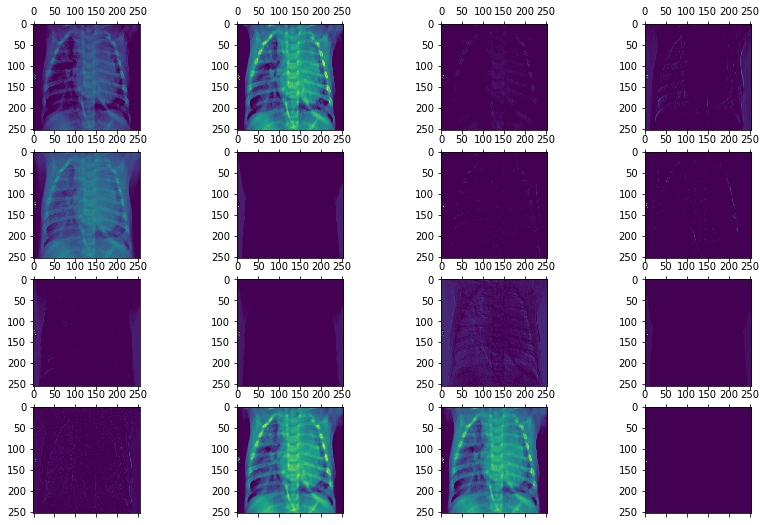

In [242]:
#plot feature maps for first convolutional layer
fig, axes = plt.subplots(4, 4, figsize=(14,9))
for i in range(16):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

The above images show how different feature maps are created in each convolutional channel in order to identify unique patterns.

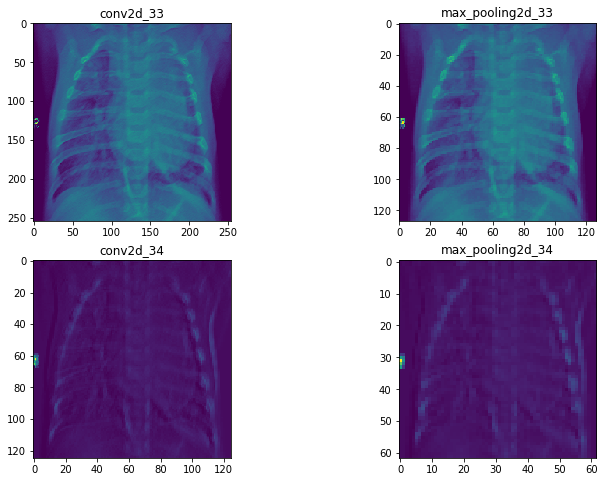

In [244]:
# plot the same channel for the 4 differnt convolutional layers
fig, axes = plt.subplots(2,2, figsize=(12,8))

layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

for i in range(4):
    row = i//2
    column = i%2
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 4], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

The above images show how the convolutional layers create more abstract images for the model to learn.

#### Classification Explanations
The images will be run through lime's image explainer to identify what parts of the images are being identified as pneumonia

In [226]:
# instantiate explainers for bacteria and viral pneumonia
bacteria_explainer = lime_image.LimeImageExplainer()
viral_explainer = lime_image.LimeImageExplainer()

In [227]:
# get explaination instance for images
bacteria_explanation = explainer.explain_instance(bacteria_img_tensor[0].astype('double'), model.predict, 
                                         top_labels=2, hide_color=0, num_samples=1000)

viral_explanation = explainer2.explain_instance(viral_img_tensor[0].astype('double'), model.predict, 
                                         top_labels=2, hide_color=0, num_samples=1000)

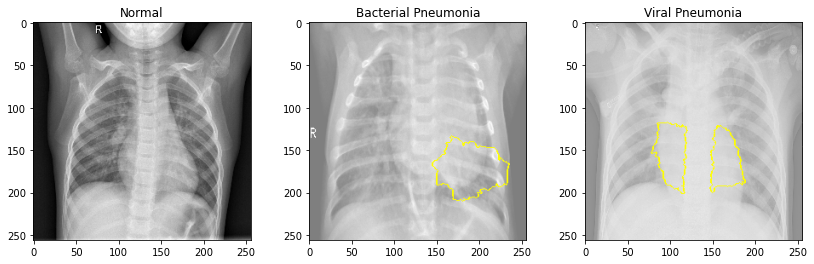

In [231]:
# plot bacteria and viral pneumonia explanations
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

# get bacterial pneumonia explanation
bacteria_temp, bacteria_mask = bacteria_explanation.get_image_and_mask(
    bacteria_explanation.top_labels[0], positive_only= False, 
    negative_only=True, num_features=3, hide_rest=False)

# get viral pneumonia explanation
viral_temp, viral_mask = viral_explanation.get_image_and_mask(
    viral_explanation.top_labels[0], positive_only= False, 
    negative_only=True, num_features=2, hide_rest=False)

# plot normal vs bacterial and viral pneumonia
ax[0].imshow(normal_img_tensor[0]);
ax[0].set_title('Normal');
ax[1].imshow(mark_boundaries(bacteria_temp / 2 + 0.5, bacteria_mask));
ax[1].set_title('Bacterial Pneumonia');
ax[2].imshow(mark_boundaries(viral_temp / 2 + 0.5, viral_mask));
ax[2].set_title('Viral Pneumonia');

The model shows the bacterial pneumonia can be identified from a localized cloudy area in the xray, wheres viral pneumonia can appear more disperse across the chest xray. The normal xray does have these cloudier features.

## Conclusion

- **Use model in evaluating potential pneumonia patients:** With a 96% accuracy, the model should be used in conjunction with the standard manual diagnosis process to help reduce errors in pneumonia detection.
- **Run model for all chest xrays:** The model should be run for all chest xrays, not just when pneumonia is expected. This will prevent missing it in cases where the doctors may not be closely looking for it.
- **Use model to train hospital doctors:** The model can be used to train doctors where to look for pneumonia and what to look for.

## Next Steps

- **Test model on adult chest xrays:** the current model was built to identify pneumonia in pediatric patients ages 1-5. Future models should be generalized to work for all age groups.
- **Further hyperparameter and architecture tuning to see if accuracy can be further improved:** due to the processing time needed for these models, only so much variable and architecture tuning was possible. Further tuning may improve the model.
- **Create multi-class model that can identify other conditions/diseases in the chest xray:** Having a classification model that can identify multiple conditions that can be seen on a chest xray will further improve efficiency in the hospital.